<a href="https://colab.research.google.com/github/sanntana21/character_recognition_with_siamese_network/blob/main/proyectoFinalVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
# **Proyecto Final Visión por Computadora 2022-2023**
---


##**Alumno 1** : Miguel García López
##**Alumno 2** : Álvaro Santana Sánchez


<img src="https://drive.google.com/uc?export=view&id=14m680B612TzlB7QpsKPwDVVomn-dYUxU">

---


# **Descripción del proyecto/tarea realizado:**

Adaptación de red siamesa preentrenada para reconocimiento de caracteres manuscritos.

# **Descripción de la BBDD usada con descripción de los conjuntos de entrenamiento y test generados:**

El conjunto de datos de Omniglot está diseñado para desarrollar algoritmos de aprendizaje más parecidos a los humanos. Contiene 1623 caracteres escritos a mano diferentes de 50 alfabetos diferentes. Cada uno de los 1623 caracteres fue dibujado en línea a través de Mechanical Turk de Amazon por 20 personas diferentes. Las particiones de training y test serán realizadas a lo largo de este cuaderno.

# **Enlace a los datos de entrenamiento y test**:

https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip (hay un directorio para test, pero nosotros haremos nuestras propias particiones).

# **Descripción y justificación del modelo/aproximación usado:**

Para la red siamesa utilizaremos la red preentrenada de Resnet34. Restnet34 está entrenado previamente en el conjunto de datos de ImageNet que contiene más de 100 000 imágenes en 200 clases diferentes. Utilizaremos todo ese conocimiento previamente extraído y haremos transfer learning y fine-tuning del modelo para adaptarlo a nuestro problema.

# **Descripción de las mejoras aportadas al modelo inicial:**...............



In [ ]:
import sys
import subprocess
import pkg_resources

required = {'nbdev', 'fastbook','pillow'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
print(missing)

if 'nbdev' in missing:
    print("INSTALLING nbdev")
    !pip install nbdev
!pip list |grep nbdev
if 'fastbook' in missing:
    print("INSTALLING fastbook")
    !pip install -Uqq fastbook
if 'pillow' in missing:
    print("INSTALLING pillow")
    !pip install pillow

!pip list |grep fastbook


set()
nbdev                         2.3.9
fastbook                      0.0.29


- Instalamos bibliotecas necesarias para el proyecto.

In [ ]:
# Now we SET UP Fastai
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.27 installed
fastai version 2.7.10 installed


In [ ]:
# Descarga el dataset Omniglot desde la página web del proyecto
# Background hace referencia a los archivos de training
# Evaluation hace referencia a los archivos de test
import os

if not os.path.isdir('omniglot'):
  !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
  !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

  # Descomprime los archivos descargados
  !unzip images_background.zip -d omniglot
  !unzip images_evaluation.zip -d omniglot
else:
  print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


- Descargamos el dataset Omniglot desde su página web. Si ya está descargado no es necesario volver a ejecutar wget. Una vez descargado los datos los descomprimimos para su fácil manipulación.

In [ ]:
from pathlib import PosixPath
import os

def get_label(name):
    # Separa la ruta en una lista de directorios
    directories = name.split(os.sep)

    # Obtiene todos los elementos de la lista excepto el último (que es el nombre del archivo)
    parents = directories[2:-1]

    # Concatena las cadenas de texto usando el método join
    label = '_'.join(parents)

    return label

files = []
files = [ path.as_posix() for path in Path('omniglot').glob('images_background/**/*.png')]
labels = list(set([get_label(i) for i in files]))
instancias_clase = {l: [f for f in files if get_label(f) == l] for l in labels}

print(files[0])
print(labels[0])
print(f'Numero de instancias: {len(files)}')
print(f'Numero de etiquetas: {len(labels)}')
print(instancias_clase[labels[0]])

omniglot/images_background/Futurama/character14/0338_11.png
Burmese_(Myanmar)_character04
Numero de instancias: 19280
Numero de etiquetas: 964
['omniglot/images_background/Burmese_(Myanmar)/character04/0773_09.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_13.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_17.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_06.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_18.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_07.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_08.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_12.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_03.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_11.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_16.png', 'omniglot/images_background/Burmese_(Myanmar)/character04/0773_1

- Definimos la función get_label, la cual nos retornará la etiqueta correspondiente del archivo que le pasemos por parámetro. Lo que se le pasa, "name", es la ruta del archivo en cuestión. A nosotros nos interesa la clase de este y no el nombre el archivo, por ello concatenamos su tipo de alfabeto y su clase en una única variable.
- Agrupamos todos los archivos png en la variable files y para cada uno encontramos su etiqueta. Creamos un diccionario llamado "instancias_clase" donde cada clave "l" es una etiqueta (label) específica de una lista de archivos "files". Por cada etiqueta "l" en la lista "labels", se crea una lista de archivos "f" en "files" donde la función "get_label(f)" es igual a "l", de forma que tengamos acceso a los datos de manera eficiente.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

#Función encargada de abrir una imágene como un tensor de torch
# file_name : path de la imágen en cuestión
def open_image_as_tensor(file_name):
    img = cv2.imread(file_name,1).astype('float32')
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1)/255.0

open_image_as_tensor(files[0]).shape

torch.Size([3, 105, 105])

- Definimos la función "open_image_as_tensor", pues será la entrada de nuestra red siamesa. Leemos la imagen a color (ya que Resnet34 está definida para imágenes tricanal) y en tipo flotante. Después convertimos la imagen a tensor y cambiamos la forma de este con la función permute. Esto es así ya que la red en ciertas capas esperará tensores cuyas dimensiones estén así ordenadas, primero los canales y después alto y ancho de la imagen.

In [ ]:
class SiameseImage(Tuple):
  def show(self, ctx=None, **kwargs):
    im1, im2, is_same = self
    return show_image(torch.cat([im1,im2], dim=1), title=is_same, ctx=ctx, **kwargs)

class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image_as_tensor(file1),open_image_as_tensor(file2)
        return SiameseImage((img1,img2,same))

    def _draw(self, f):
        same = random.random() < 0.5
        cls = get_label(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(instancias_clase[cls]),int(same)

- Definimos la clase SiameseTuple (que hereda de la clase Tuple) para poder representar visualmente de manera cómoda nuestras imágenes siamesas. Muestra por pantalla las dos imágenes concatenándolas con torch.cat.

- Definimos también la clase SiameseTransform (hereda de la clase Transform, pues vamos a aplicar transformaciones a nuestros archivos de manera que podamos crear un dataset para train y validation de manera correcta y compatible con Fastai. SiameseTransform consta de tres métodos, el primero es el de inicialización, "__init__", el cual declara los atributps de clase y, si is_valid == TRUE, creamos la losta de files2 con el método "draw2.

- El método "_draw" toma como entrada un archivo "f", determina si las dos imágenes son de la misma clase o no mediante un número aleatorio, obtiene la etiqueta "cls" del archivo utilizando la función "get_label", y elige un archivo aleatorio de la lista "instancias_clase" utilizando la etiqueta "cls" obtenida anteriormente. Si las dos imágenes no van a ser de la misma clase, se elige una etiqueta diferente a "cls" de la lista "labels" y se elige un archivo de la lista "instancias_clase" utilizando esta etiqueta. El método devuelve el archivo elegido y la etiqueta "same" (verdadero o falso) como una tupla. Gracias a este método crearemos nuestra partición de validación.

- El método encodes codifica la entrada y devuelve una instancia de la propia clase con las dos imágenes en cuestión y la etiqueta correspondiente. Las imágenes se abren con la función de open_image_as_tensor anteriormente definida.

- Estas funciones han sido sacadas de: https://docs.fast.ai/tutorial.siamese.html, donde se explica detalladamente el preprocesado de datos.

In [ ]:
train_size = int(len(files)*0.8)

train_files,valid_files = files[:train_size],files[train_size:]
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

- Creamos las particiones de train y valid utilizando TfmdLists. Esta función aplica las transformaciones anteriormente definidas a las listas que contienen los archivos de validación y de entrenamiento.

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

- Creamos el dataloader con algunas transformaciones tales como Normalización (teniendo de referencia las estadísticas del dataset de imagenet) y el aumento de datos con las transformaciones por defecto.

- Hacemos dls = dls.cuda() para mover los datos desde la memoria de la CPU a la memoria de la GPU. Esto se utiliza para acelerar el procesamiento de los datos al utilizar la capacidad de cálculo paralelo de la GPU.

In [ ]:
batch = dls.one_batch()

- Obtenemos un batch del dataloader para comprobar que todo está correctamente definido.

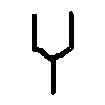

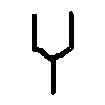

tensor(0, device='cuda:0')


In [ ]:
from torchvision import transforms

file1,file2,lable = batch[0][10], batch[1][10], batch[2][10]
im1 = (file1.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
im2 = (file1.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
cv2_imshow(im1)
cv2_imshow(im2)
print(lable)
#im1 = transforms.ToPILImage()(batch[0][-10]).convert("RGB")
#im2 = transforms.ToPILImage()(batch[1][-10]).convert("RGB")
#display(im1, im2)

- Comprobamos que las imágenes se pueden visualizar de manera correcta y que la etiqueta corresponde con lo visualizado.

In [ ]:
from fastai.vision import *

class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

encoder = create_body(resnet34(weights=ResNet34_Weights.IMAGENET1K_V1), cut=-2)
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

- Vamos a definir nuestra red siamesa preentrenada. Para ello creamos la clase SiameseModel, con su correspondiente método __init__ y su método forward. Forward simplemente propaga hacia adelante los datos, en este caso al ser una red siamesa tenemos dos entradas, que son x1 y x2, ambas las pasamos al encoder (que en nuestro caso es una red Resnet34 preentrenada). Creamos ftrs (features) concatenando la salida de los dos redes y se lo pasamos a la cabeza o head que hemos definido.

- La cabeza o head simplemente será una red totalmente conectada con 512 * 2 entradas y 2 salidas, debido a que es una red siamesa. Además tiene una posibilidad de aplicar dropout del 50%. No es crucial intentar diseñar una cabeza muy enrevesada, pues la extracción de caratcerísticas, que al fin y al cabo es la parte esencial, será llevaba a cabo por el cuerpo de Resnet34.

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),splitter=siamese_splitter, metrics=accuracy)
learn.freeze()
learn.summary()

SiameseModel (Input shape: 64 x 3 x 105 x 105)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 53 x 53   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 27 x 27   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                    

- Creamos un splitter personalizado para la red Siamesa, de forma que cuando congelemos los pesos preentrenados de Resnet34 solo se entrene la cabeza. La función del splitter es dividir cuerpo de cabeza para poder aplicar este congelamiento de capas.

- Definimos el objeto learn con el objetivo de mejorar la métrica de "accuracy" y con una función de pérdida de CrossEntropyFlat. CrossEntropyFlat, al igual que CrossEntropy, calcula la pérdida de entropía cruzada entre los logits de entrada y el objetivo. Es útil cuando se entrena un problema de clasificación con clases C, en nuestro caso C=2 {0, 1}. La única diferencia está en que CrossEntropyFlat aplana la entrada y la salida, lo cual suele funcionar mejor (puramente empírico).

In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.518871,0.421541,0.805757,00:54
1,0.305043,0.265727,0.897822,00:53
2,0.223095,0.214413,0.917012,00:53
3,0.193381,0.197978,0.924015,00:53


- Entrenamos 4 etapas con los pesos de Resnet34 congelados.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.172686,0.192144,0.928683,01:13
1,0.172125,0.188428,0.932832,01:13
2,0.162131,0.185681,0.931276,01:13
3,0.173608,0.187466,0.930757,01:13


- Descongelamos los pesos y entrenamos 4 etapas más para adaptar mínimamente los pesos a nuestro problema y conseguir un poco más de precisión.

- Si nos fijamos en la pérdida de training y de validation, podemos observar que ambas decrecen a un ritmo muy similar. Lo ideal sería que la pérdida de training fuese un límite superior de la pérdida de validación. En este caso, es cierto que validación llega a superar mínimamente a training, pero no es nada grave. Una diferencia mayor indicaría que sufrímos overfitting, pero en nuestro caso el aprendizaje se para antes de que ocurra este fenómeno.

In [ ]:
files_test = [ path.as_posix() for path in Path('omniglot').glob('images_evaluation/**/*.png')]
labels = list(set([get_label(i) for i in files_test]))
instancias_clase = {l: [f for f in files_test if get_label(f) == l] for l in labels}

print(files_test[0])
print(labels[0])
print(f'Numero de instancias: {len(files_test)}')
print(f'Numero de etiquetas: {len(labels)}')
print(instancias_clase[labels[0]])

omniglot/images_evaluation/Keble/character14/1259_06.png
Keble_character05
Numero de instancias: 13180
Numero de etiquetas: 659
['omniglot/images_evaluation/Keble/character05/1250_05.png', 'omniglot/images_evaluation/Keble/character05/1250_10.png', 'omniglot/images_evaluation/Keble/character05/1250_03.png', 'omniglot/images_evaluation/Keble/character05/1250_16.png', 'omniglot/images_evaluation/Keble/character05/1250_01.png', 'omniglot/images_evaluation/Keble/character05/1250_11.png', 'omniglot/images_evaluation/Keble/character05/1250_20.png', 'omniglot/images_evaluation/Keble/character05/1250_04.png', 'omniglot/images_evaluation/Keble/character05/1250_15.png', 'omniglot/images_evaluation/Keble/character05/1250_08.png', 'omniglot/images_evaluation/Keble/character05/1250_07.png', 'omniglot/images_evaluation/Keble/character05/1250_13.png', 'omniglot/images_evaluation/Keble/character05/1250_06.png', 'omniglot/images_evaluation/Keble/character05/1250_18.png', 'omniglot/images_evaluation/Keb

In [ ]:
def One_shot_one_batch_test(batch,batch_size,predictor_model,show_results = False):

  GREEN = '\033[92m'
  END = '\033[0m'
  RED = '\033[91m'

  hits = 0

  for i in range(batch_size):
    file1,file2,label = batch[0][i], batch[1][i], batch[2][i]
    im = torch.cat([file1,file2], dim=2)
    im = (im.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)

    label_np = label.cpu().numpy()
    prediction = predictor_model.predict(SiameseImage((file1,file2,label)))
    #Predict devuelve las codificaciones: 1. del modelo, 2. decodificada, 3. completamente decodificada
    model_prediction,_,_ = prediction[0].item(),prediction[1].item(),prediction[2]
    if model_prediction == label:
      hits += 1
      COLOR = GREEN
    else:
      COLOR = RED

    if show_results and i > batch_size - 10:
      if model_prediction == 1:
          print(f"{COLOR}IGUALES : {model_prediction}{END}")
      else:
          print(f"{COLOR}DIFERENTES : {model_prediction}{END}")
      cv2_imshow(im)

  return hits*100/batch_size


- La función "One_shot_one_batch_test" se utiliza para evaluar el rendimiento de nuestra red siamesa. Toma como entrada un lote de datos (batch) de tamaño específico (batch_size), junto con el modelo predictor (predictor_model). La función itera a través del batch y para cada elemento, concatena dos imágenes y las convierte en un formato de numpy. Luego, utiliza el modelo predictor para hacer una predicción sobre si las dos imágenes son iguales o diferentes. Si la predicción es correcta, se registra un acierto y se utiliza un color verde para indicarlo en la salida. Si la predicción es incorrecta, se registra un error y se utiliza un color rojo para indicarlo en la salida.

- Al final, la función devuelve el porcentaje de aciertos obtenidos sobre el total de elementos en el lote. Además tiene una opcion de mostrar los resultados. Si es True, muestra las últimas 10 imágenes y su predicción.

In [ ]:
test_size = 2000
test_tl= TfmdLists(range(len(files_test)), SiameseTransform(files_test))
test_dls = DataLoaders.from_dsets(test_tl,shuffle=True,batch_size=test_size, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
test_dls = test_dls.cuda()

- Creamos el conjunto de test para obtener el resultado final y evaluar nuestra red.

DIFERENTES : 0


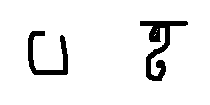

IGUALES : 1


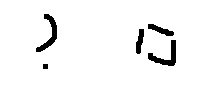

DIFERENTES : 0


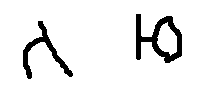

DIFERENTES : 0


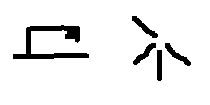

DIFERENTES : 0


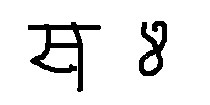

IGUALES : 1


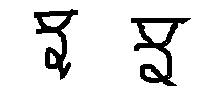

IGUALES : 1


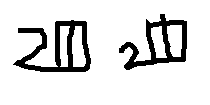

IGUALES : 1


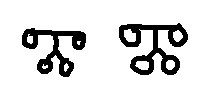

IGUALES : 1


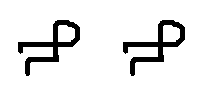

91.25


In [ ]:
dls_iterator = iter(test_dls[0])
batch = next(dls_iterator)
porcentaje = One_shot_one_batch_test(batch,batch_size=test_size,predictor_model=learn,show_results = True)
print(porcentaje)

- De media, nuestra red siamesa obtiene un ajuste del 90% de precisión, obteniendo en algunos casos resultados cercanos al 95%.

# **ANEXO 1 :Contrastive Loss**

- Contrastive Loss es una función de pérdida que se utiliza para aprender representaciones de datos que sean sensibles a las diferencias entre ellos.
La función de pérdida contrastiva se basa en la idea de que los ejemplos similares deben tener una distancia euclidiana más corta en el espacio de características (representación) que los ejemplos no similares.

- La función de pérdida contrastiva se define como la suma de la mitad de la distancia euclidiana al cuadrado entre las representaciones de dos ejemplos similares, menos la mitad de la distancia al cuadrado entre las representaciones de dos ejemplos no similares, más una cierta constante. Originalmente:

$$L = ( 1 - Y ) * || x_i - x_j ||^2 + Y * max(0,m - ||x_i - x_j||^2)$$

- Para que el efecto de la función de pérdida sea el deseado se deben modificar las etiquetas según se estaban utilizando ya que buscamos que:

  1. Cuando dos imágenes son similares (Y=0) entonces minimizamos la distancia Euclidea entre ambos $|| x_i - x_j ||^2$

  2. En el caso contrario, los ejemplos son diferentes y maximizamos la distancia Euclídea $max(0,m - ||x_i - x_j||^2)$ hasta un máximo el cual se corresponde con el parámetro **margin**.

- Cuanto mayor sea el margen establecido, mayor diferenciación entre las imágenes podrá aprenderse, siendo el modelo más sensible a las diferencias. Un valor usual suele ser 1, ya que de esta forma establecemos los dos extremos del espectro. En nuestro caso lo situaremos a 2 para observar mejor los resultados.


- Vamos a probar a utilizar esta función de pérdida en vez de CrossEntropy y vamos a analizar los resultados.



In [ ]:
#Cambio de etiquetas respecto del modelo anterior
# Y = 0 -> clases similares
# Y = 1 -> clases diferentes
class SiameseTransformContrastiveLoss(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image_as_tensor(file1),open_image_as_tensor(file2)
        return SiameseImage((img1,img2,same))

    def _draw(self, f):
        same = random.random() < 0.5
        label = True
        if same: label = False
        cls = get_label(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(instancias_clase[cls]),int(label)

In [ ]:
#Definimos la funcion de perdida
class ContrastiveLoss(BaseLoss):
    def __init__(self, margin=1.0, loss_cls=nn.CrossEntropyLoss, **kwargs):
        super().__init__(loss_cls=loss_cls, **kwargs)
        self.margin = margin

    def forward(self, output, target):
        n = output.shape[0]
        output1, output2 = output[:n//2], output[n//2:]
        target = target.float()

        # distancia euclidiana entre los pares
        dist = F.pairwise_distance(output1, output2)
        loss = torch.mean(0.5 * (1-target) * torch.pow(dist, 2) + 0.5 * (target) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))
        return loss

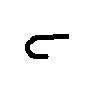

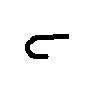

In [ ]:
# Crear de nuevo los batches para el entrenamiento
files = [ path.as_posix() for path in Path('omniglot').glob('images_background/**/*.png')]
labels = list(set([get_label(i) for i in files]))
instancias_clase = {l: [f for f in files if get_label(f) == l] for l in labels}

#Creamos de nuevo el conjunto de entrenamiento
train_size = int(len(files)*0.8)
train_files,valid_files = files[:train_size],files[train_size:]
train_tl= TfmdLists(range(len(train_files)), SiameseTransformContrastiveLoss(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransformContrastiveLoss(valid_files, is_valid=True))
dls = DataLoaders.from_dsets(train_tl, valid_tl, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()
batch = dls.one_batch()

#Mostramos la primera instancia del batch para comprobar su funcionamiento
file1,file2,lable = batch[0][10], batch[1][10], batch[2][10]
im1 = (file1.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
im2 = (file1.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
cv2_imshow(im1)
cv2_imshow(im2)

In [ ]:
# Crear un objeto ContrastiveLoss
contrastive_loss = ContrastiveLoss(margin=1.0)

# Crear un objeto Learner
learn = Learner(dls, model, loss_func=contrastive_loss,splitter=siamese_splitter, metrics=accuracy)
learn.freeze()
learn.summary()

SiameseModel (Input shape: 64 x 3 x 105 x 105)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 53 x 53   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 27 x 27   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                    

In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.363887,0.275016,0.891338,01:01
1,0.205254,0.220816,0.917272,01:02
2,0.169195,0.190687,0.929461,01:01
3,0.143241,0.183899,0.930498,01:02


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.140805,0.184193,0.934129,01:19
1,0.136936,0.174003,0.935166,01:12
2,0.128235,0.174297,0.936722,01:13
3,0.138389,0.174314,0.934647,01:12


In [ ]:
files_test = [ path.as_posix() for path in Path('omniglot').glob('images_evaluation/**/*.png')]
labels = list(set([get_label(i) for i in files_test]))
instancias_clase = {l: [f for f in files_test if get_label(f) == l] for l in labels}
test_size = 200
test_tl= TfmdLists(range(len(files_test)), SiameseTransformContrastiveLoss(files_test))
test_dls = DataLoaders.from_dsets(test_tl,shuffle=True,batch_size=test_size, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
test_dls = test_dls.cuda()
dls_iterator = iter(test_dls[0])
batch = next(dls_iterator)

4.751238822937012


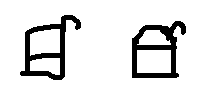

2.0667550563812256


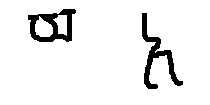

15.298718452453613


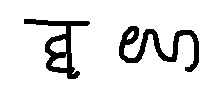

7.2920918464660645


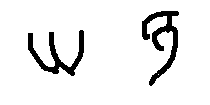

2.307598114013672


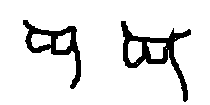

3.848081111907959


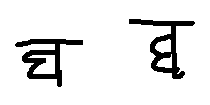

6.9207024574279785


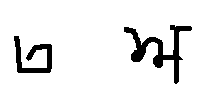

0.8746513724327087


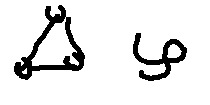

4.119956016540527


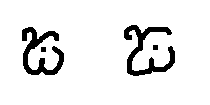

In [ ]:
def New_one_shot_one_batch_test(batch,batch_size,predictor_model,show_results = False):

  GREEN = '\033[92m'
  END = '\033[0m'
  RED = '\033[91m'

  hits = 0

  for i in range(batch_size):
    file1,file2,label = batch[0][i], batch[1][i], batch[2][i]
    im = torch.cat([file1,file2], dim=2)
    im = (im.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)

    label_np = label.cpu().numpy()
    prediction = predictor_model.predict(SiameseImage((file1,file2,label)))
    #Predict devuelve las codificaciones: 1. del modelo, 2. decodificada, 3. completamente decodificada
    model_prediction = F.pairwise_distance(prediction[0][0], prediction[0][1]).item()
    if show_results and i > batch_size - 10:
      print(model_prediction)
      cv2_imshow(im)

New_one_shot_one_batch_test(batch,batch_size=10,predictor_model=learn,show_results = True)

La implementación de esta función se basa en el siguiente video explicativo:

https://www.youtube.com/watch?v=9hLcBgnY7cs

# **ANEXO 2: N-way**

- Vamos a medir el funcionamiento de la red en predicciones más complejas. Utilizaremos un conjunto de imágenes que incluyan la misma clase que la instancia original junto a otras 8 imágenes de diferentes clases. El uso de Contrastive Loss nos ha permitido tener una medida sobre la similitud de dos imágenes y obtener predicciones más exactas sobre la cercanía de dos símbolos.

- La idea consiste en comparar la imágen original con cada una de las 9 entradas posibles. Aquella otra imágen que sea de la misma categoría que la original debe ser aquella para la cuál la salida de una menor distancia.

- Por tanto, dentro de un conjunto N-way daremos como incorrectas aquellas predicciones que den una distancia euclídea entre las imágenes menor que la distancia euclídea de las imágenes de la misma clase.






In [ ]:
def Single_N_way_test(batch,batch_size,N,predictor_model):

  GREEN = '\033[92m'
  END = '\033[0m'
  RED = '\033[91m'
  OTHER = '\033[95m'

  total_images = 0
  same_class_prediction = 0
  encontrada = False

  for i in range(batch_size):
    if total_images < N:
      file1,file2,label = batch[0][i], batch[1][i], batch[2][i]
      if label == 0 and total_images < 1:
        original = file1
        encontrada = True
      if encontrada:
        im = torch.cat([original,file2], dim=2)
        im = (im.cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)

        label_np = label.cpu().numpy()
        prediction = predictor_model.predict(SiameseImage((original,file2,0)))
        #Predict devuelve las codificaciones: 1. del modelo, 2. decodificada, 3. completamente decodificada
        model_prediction = F.pairwise_distance(prediction[0][1], prediction[0][0]).item()
        if total_images < 1:
          same_class_prediction = model_prediction
          print(f"{OTHER} PREDICCION CLASE SIMILAR: {model_prediction}{END}")
        else:
          if model_prediction >= same_class_prediction:
            print(f"{GREEN} PREDICCION: {model_prediction}{END}")
          else:
            print(f"{RED} PREDICCION: {model_prediction}{END}")

        cv2_imshow(im)
        total_images += 1


 PREDICCION CLASE SIMILAR: 1.502200722694397


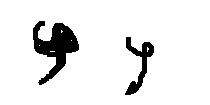

 PREDICCION: 3.5804214477539062


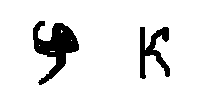

 PREDICCION: 2.0857033729553223


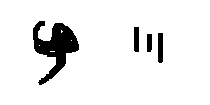

 PREDICCION: 0.5586055517196655


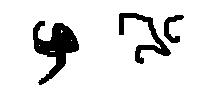

 PREDICCION: 0.4066735506057739


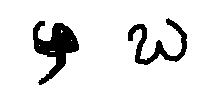

 PREDICCION: 2.092989921569824


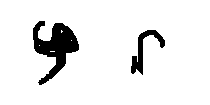

 PREDICCION: 1.9646143913269043


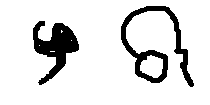

In [ ]:
Single_N_way_test(batch,batch_size=10,N=10,predictor_model=learn)

- En general las predicciones realizadas sobre conjuntos grandes de símbolos suelen ser acertadas. Sin embargo en ciertas ocasiones encontraremos fallas que pueden ser debidas a muchas razones. En general, si situamos como objeto de reconocimiento caras o imágenes complejas la cantidad de rasgos a poder ser aprendidos por la red es mayor que en el reconocimiento de símbolos. Ciertos de estos símbolos tienen poca diferenciación, siendo esta en algunos casos la falta de trazos. Estás imágenes parecen sufrir penalización en este N-way shot, ya que las distancias euclidianas respecto de estas se ven más moderadas.

- Por otro lado los porcentajes de accuracy en la tarea de reconocimiento se mantienen altos y por tanto la tarea de discernir si dos imágenes son de la misma clase se puede seguir realizando con éxito.